# Road Sign Detection from Scratch using PyTorch

In [1]:
# Installing libraries
!pip install opendatasets --quiet --upgrade
!pip install albumentations --quiet --upgrade
!pip install torchinfo --quiet --upgrade

import os
import numpy as np
import pandas as pd
from pathlib import Path
import opendatasets as od
from xml.etree import ElementTree
from collections import Counter
from tqdm.auto import tqdm
import time

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

## Downloading and Processing Dataset

In [2]:
# Configuring the device for cpu and cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data_path = Path('data')

# Downloading dataset
if data_path.exists():
    print('[INFO] Data directory exists, skipping dataset download command')
else:
    print('[INFO] Downloading dataset.')
    data_path.mkdir()
    od.download_kaggle_dataset(dataset_url='https://www.kaggle.com/datasets/andrewmvd/road-sign-detection',
                               data_dir=data_path)

[INFO] Data directory exists, skipping dataset download command


In [4]:
# Defining the image and annotation directories
annot_path = Path('data/road-sign-detection/annotations')
image_path = Path('data/road-sign-detection/images')

In [5]:
# Counting and confirming files
image_list = sorted([image_path / i for i in os.listdir(image_path)])
annot_list = sorted([annot_path / i for i in os.listdir(annot_path)])

unique = []
for i in [image_list, annot_list]:
    for j in i:
        if j.suffix not in unique:
            unique.append(j.suffix)
unique, len(image_list), len(annot_list)

(['.png', '.xml'], 877, 877)

In [6]:
# Creating a dataframe containing meta data of images
image_meta_list = []
for i in image_list:
    meta = {}
    meta['image_path'] = i
    meta['height'], meta['width'] = Image.open(i).size
    meta['ratio'] = round(meta['width'] / meta['height'], 2)
    image_meta_list.append(meta)
meta_df = pd.DataFrame(image_meta_list) 
meta_df

,image_path,height,width,ratio
0,data/road-sign-detection/images/road0.png,267,400,1.50
1,data/road-sign-detection/images/road1.png,400,283,0.71
2,data/road-sign-detection/images/road10.png,400,267,0.67
3,data/road-sign-detection/images/road100.png,400,385,0.96
4,data/road-sign-detection/images/road101.png,400,200,0.50
...,...,...,...,...
872,data/road-sign-detection/images/road95.png,300,400,1.33
873,data/road-sign-detection/images/road96.png,400,267,0.67
874,data/road-sign-detection/images/road97.png,400,267,0.67
875,data/road-sign-detection/images/road98.png,400,267,0.67


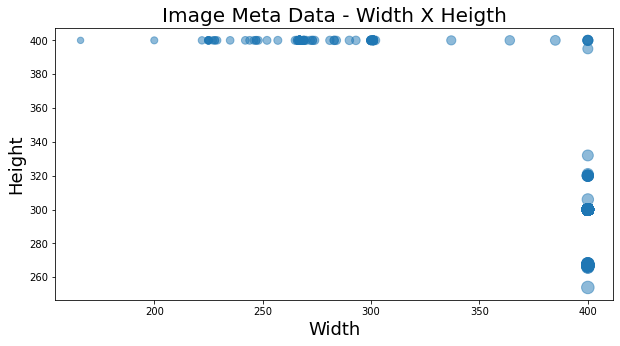

In [7]:
# # Visualizing the dataframe as a scatter plot.
plt.figure(figsize=(10, 5))
plt.scatter(x=meta_df.width, y=meta_df.height, alpha=0.5, s=meta_df.ratio*100)
plt.xlabel('Width', {'fontsize': 18})
plt.ylabel('Height', {'fontsize': 18})
plt.title('Image Meta Data - Width X Heigth', {'fontsize': 20});

Min - 224 X 224 and  Max - 400 X 400

In [8]:
# Creating custom pytorch dataset using the images and annot data
class RoadSignDataset(torch.utils.data.Dataset):
    """
    """
    def __init__(self, image_dir, annot_dir, height, width, transforms=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.height = height
        self.width = width
        self.transforms = transforms

        # Images and annots list
        self.image_list = [image for image in sorted(os.listdir(self.image_dir))]
        self.annot_list = [annot for annot in sorted(os.listdir(self.annot_dir))]

        # List of classes
        self.classes = ['crosswalk', 'speedlimit', 'stop', 'trafficlight']

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]
        annot_name = self.annot_list[index]
        image_path = os.path.join(self.image_dir, image_name)
        annot_path = os.path.join(self.annot_dir, annot_name)

        # Reading the image and coverting it to RGB format
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        # Resize and normalize the image
        img_resize = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_resize /= 255.

        # Getting the original height and width of the image
        ht = img.shape[0]
        wt = img.shape[1]

        # Collecting details from xml file
        bboxes = []
        labels = []
        tree = ElementTree.parse(annot_path)
        root = tree.getroot()
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            # Finding the bounding box values
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            # Resizing the bounding box
            xmin_resize = (xmin/wt)*self.width
            xmax_resize = (xmax/wt)*self.width
            ymin_resize = (ymin/ht)*self.height
            ymax_resize = (ymax/ht)*self.height

            # Correcting bounding box
            if xmin_resize > float(self.width):
                xmin_resize = float(self.width)
            if xmax_resize > float(self.width):
                xmax_resize = float(self.width)
            if ymin_resize > float(self.height):
                ymin_resize = float(self.height)
            if ymax_resize > float(self.height):
                ymax_resize = float(self.height)
            bboxes.append((xmin_resize, ymin_resize, xmax_resize, ymax_resize))
            
            # Converting data to tensors
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Applying transform
            if self.transforms:
                img_resize = self.transforms(image = img_resize)
            return img_resize, bboxes, labels

In [9]:
# Check the dataset
dataset = RoadSignDataset(image_dir=image_path,
                          annot_dir=annot_path,
                          height=224,
                          width=224)
print(f'Length of dataset: {len(dataset)}')
img, bbox, label = dataset[5]
print(f'Image shape: {img.shape}')
print(f'bounding box details: {bbox}')
print(f'label details: {label}')

Length of dataset: 877
Image shape: (224, 224, 3)
bounding box details: tensor([[ 20.7200,  31.8801, 136.0800, 205.5431]])
label details: tensor([1])


Count of images for all classes: {'trafficlight': 61, 'speedlimit': 652, 'crosswalk': 88, 'stop': 76}


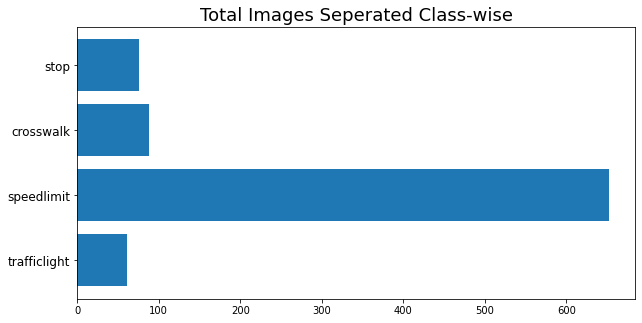

In [10]:
# lets check the image count for every class.
classes_list = []
for i in range(len(dataset)):
    img, bbox, label = dataset[i]
    classes_list.append(dataset.classes[label.item()])
classes_dict = Counter(classes_list)
print(f'Count of images for all classes: {dict(classes_dict)}')

# Plotting the image count
names, values = list(classes_dict.keys()), list(classes_dict.values())
plt.figure(figsize=(10, 5))
plt.barh(range(len(classes_dict)), classes_dict.values())
plt.yticks(np.arange(4), list(classes_dict.keys()), fontsize=12)
plt.title('Total Images Seperated Class-wise', fontsize=18);

In [11]:
# Function for visualizing image
def plot_image(img_array):
    """
    A function to display an single image.
    Parameters:
        img_array: A numerical array or tensor of an image in a shape compatible with Matplotlib.
                   Image can be read by any method for e.g. plt.imread() or cv2.imread().
    """
    image = img_array.copy()
    plt.imshow(image)
    plt.axis(False);

In [12]:
# Function to view images in grid
def plot_grid(dataset, rows=4, cols=4):
    """
    A function to display a grid of images.
    Args:
        dataset: A dataset with images and target data.
        rows(defaut=4): Number of rows for the grid.
        cols(default=4): Nuber of columns for the grid.
    """
    fig = plt.figure(figsize=(20, 20))
    for i in range(rows * cols):
        rand_num = np.random.randint(len(dataset))
        imgs, bbox, label = dataset[rand_num]
        fig.add_subplot(rows, cols, i+1)
        plot_image(img_array=imgs)
    plt.show();

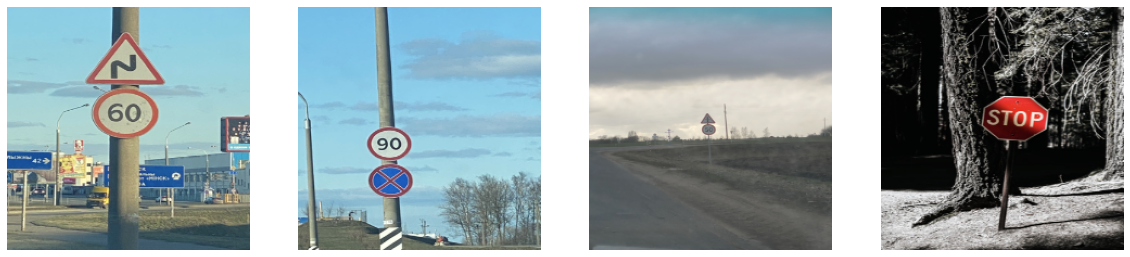

In [13]:
# Lets visualize the images
plot_grid(dataset, 1, 4)

In [14]:
# Creating function to visualize with bounding box
def class_to_color(class_id):
    """
    A function to suggest color for the bounding box as per the classes.
    Parameters:
        class_id: A int for selecting a color from a list.
    Returns:
        A tuple with three values for RGB in a format of 0 and 1.
    """
    # Classes: {'crosswalk': 'yellow', 'speedlimit': 'green', 'stop': 'red', 'trafficlight': 'blue'}
    colors = [(1, 1, 0), (0, 1, 0), (1, 0, 0), (0, 0, 1)]
    return colors[class_id]

def draw_bboxes(img_array, bboxes, labels):
    """
    A function to create bounding box with specific color as per the class.
    Parameters:
        img_array: A numerical array or tensor of an image in a shape compatible with Matplotlib.
                   Image can be read by any method for e.g. plt.imread() or cv2.imread().
        bboxes: A python List containing data for the bounding box. 
                Box format should be a pascal voc format
        labels: A python List containing data for the bounding box.
                Labels should be a int for each classes.
    """
    for i in range(len(bboxes)):
        xmin, ymin = int(bboxes[i][0]), int(bboxes[i][1])
        xmax, ymax = int(bboxes[i][2]), int(bboxes[i][3])
        class_id = labels[i]
        color = class_to_color(class_id)
        rect_array = cv2.rectangle(img_array, (xmin, ymin), (xmax, ymax), color, 2)
    return rect_array

def plot_bboxes_grid(dataset, rows=4, cols=4):
    """
    A function to display a grid of images with their bounding box.
    Parameters:
        dataset: A dataset with images and target data.
        rows(defaut=4): Number of rows for the grid.
        cols(default=4): Nuber of columns for the grid.
    """
    fig = plt.figure(figsize=(20, 20))
    for i in range(rows * cols):
        rand_num = np.random.randint(len(dataset))
        img, bbox, label = dataset[rand_num]
        fig.add_subplot(rows, cols, i+1)
        image = draw_bboxes(img_array=img, bboxes=bbox, labels=label)
        plot_image(img_array=image)
    plt.show();

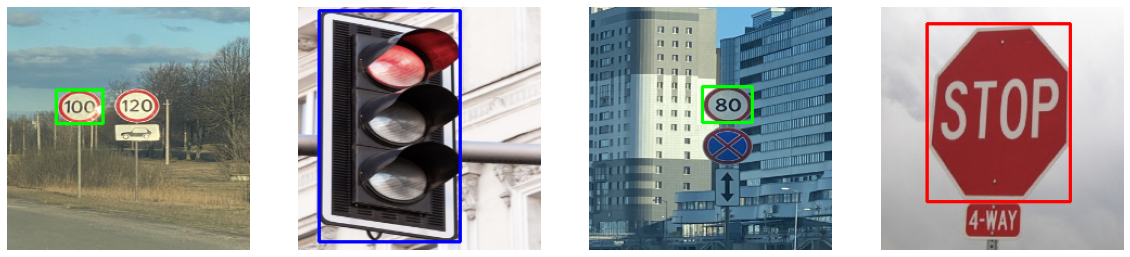

In [78]:
# Visualize the image with bounding box
plot_bboxes_grid(dataset=dataset, rows=1, cols=4)

## Augmentation

In [16]:
# Creating a function to augment images
def get_transform(train: bool):
    """
    A function to create image augmentation using the Aulbumentations package.
    Parameters:
        train: A boolean input for justifying the use of augmentation on a training or validation dataset.
    Return:
        A python dictionary containg 'image': In pytorch tensor format, 
                                     'bboxes': In pascal voc format.
                                     'labels': A int for class representation.
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    if train:
        return A.Compose([
            A.Normalize(always_apply=True, max_pixel_value=1.0),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            ToTensorV2()
        ])    

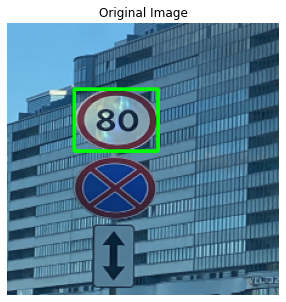

In [83]:
# Visualize and compare images
rand_num = np.random.randint(len(dataset))
img, bbox, label = dataset[rand_num]
plt.figure(figsize=(10, 5))

# original image
org_img = draw_bboxes(img_array=img, bboxes=bbox, labels=label)
plot_image(img_array=org_img)
plt.title('Original Image');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


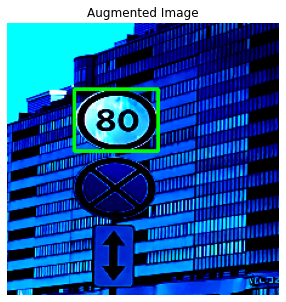

In [84]:
# augmented img
img, bbox, label = dataset[rand_num]
plt.figure(figsize=(10, 5))

img_trans = get_transform(train=True)
transformed_img = img_trans(image = img)
transformed_img = np.ascontiguousarray(transformed_img['image'].permute(1, 2, 0))
aug_img = draw_bboxes(img_array=transformed_img, 
                      bboxes=bbox, 
                      labels=label)
plot_image(img_array=aug_img)
plt.title('Augmented Image');

## Dataloader

In [19]:
# Creating dataset for training and testing
train_dataset = RoadSignDataset(image_dir=image_path, 
                                annot_dir=annot_path, 
                                height=224, 
                                width=224, 
                                transforms=get_transform(train=True))
test_dataset = RoadSignDataset(image_dir=image_path, 
                               annot_dir=annot_path, 
                               height=224, 
                               width=224, 
                               transforms=get_transform(train=False))

In [20]:
# Creating a random sequence list of digits
torch.manual_seed(42)
indices = torch.randperm(len(train_dataset)).tolist()
indices[:10]

[292, 48, 503, 93, 526, 508, 496, 411, 368, 478]

In [21]:
# Spliting dataset into a 80:20 ratio
test_ratio = 0.2
test_size = int(len(train_dataset) * test_ratio)

train_dataset = torch.utils.data.Subset(dataset=train_dataset,
                                        indices=indices[:-test_size])
test_dataset = torch.utils.data.Subset(dataset=test_dataset,
                                       indices=indices[-test_size:])
print(f'[INFO] Size of training dataset: {len(train_dataset)} and testing dataset: {len(test_dataset)}')

[INFO] Size of training dataset: 702 and testing dataset: 175


In [22]:
# Creating dataloaders using train and test dataset
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False,
                                              pin_memory=True)

In [23]:
# Lets check the dataloader
next(iter(train_dataloader))

[{'image': tensor([[[[ 0.3544,  0.6632,  0.9427,  ..., -1.0797, -1.0692, -1.0488],
            [ 0.9397,  0.3763,  0.7335,  ..., -1.0972, -1.0580, -1.0964],
            [ 0.8450,  0.5896,  1.0076,  ..., -1.0123, -1.0643, -1.0633],
            ...,
            [-0.3505, -0.3730, -0.3369,  ..., -0.1226,  0.0077,  0.0068],
            [-0.2707, -0.3585, -0.4710,  ..., -0.2475, -0.2799, -0.1480],
            [-0.3034, -0.3116, -0.4116,  ..., -0.2995, -0.6038, -0.4664]],
  
           [[ 0.6491,  1.0147,  1.3788,  ..., -0.5987, -0.5769, -0.5595],
            [ 1.2423,  0.5235,  1.0563,  ..., -0.5926, -0.5612, -0.5975],
            [ 1.0588,  0.7853,  1.3646,  ..., -0.5397, -0.6075, -0.6208],
            ...,
            [-0.0154, -0.0335, -0.0049,  ...,  0.0909,  0.2239,  0.2233],
            [ 0.0893, -0.0270, -0.1420,  ..., -0.0684, -0.1026,  0.0339],
            [ 0.0602,  0.0316, -0.0796,  ..., -0.0827, -0.3791, -0.2531]],
  
           [[ 1.1374,  1.4989,  1.8733,  ..., -0.1753, -0.158

## Object Detection Architecture

In [24]:
# Creating a base model for the architecture
def resnet50(device):
    """
    Creating a pretrained ResNet50 model.
    Return: model
    """
    # Setting up model weights and instance
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)
    
    # Freezing the weights of the model
    for param in model.parameters():
        param.requires_grad = False
    return model

resnet_base = resnet50(device=device)
resnet_base

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
class ObjectDetection(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        
        # initializing the input parameters
        self.base_model = base_model
        self.num_classes = num_classes
        
        # Building the regressor head for bounding box
        self.regressor = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        
        # Building the classifier head to predict the classes
        self.classifier = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, self.num_classes)
        )
        
        # Setting the base model head to identity mapping
        self.base_model.fc = nn.Identity()
        
    def forward(self, x):
        # passing the input to base model
        features = self.base_model(x)
            
        # passing the features to both regressor and classifier
        bboxes = self.regressor(features)
        class_logits = self.classifier(features)
            
        # return the bboxes and class_logits
        return (bboxes, class_logits)

In [26]:
# lets view the architecture
base_model = resnet50(device=device)
object_detection_model = ObjectDetection(base_model=base_model, num_classes=len(dataset.classes)).to(device)
summary(model=object_detection_model, input_size=(32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetection (ObjectDetection)             [32, 3, 224, 224]    [32, 4]              --                   Partial
├─ResNet (base_model)                         [32, 3, 224, 224]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

## Model Training

In [27]:
# Defining loss, optimizer and learning rate scheduler
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.L1Loss()

lr_rate = 1e-2
epochs = 20

optimizer = torch.optim.Adam(params=object_detection_model.parameters(), 
                             lr=lr_rate, 
                             weight_decay=1e-4)
lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                               max_lr=lr_rate, 
                                               epochs=epochs, 
                                               steps_per_epoch=len(train_dataloader))

# Function to watch and get the current learning rate
def get_lr(optimizer):
    for param in optimizer.param_groups:
        return param['lr']

In [28]:
# Creating a dictionary to store training history values
history = {'total_train_loss': [], 'total_val_loss': [], 'train_class_acc': [], 'val_class_acc': [], 'learning_rate': []}

In [29]:
# Training the model
print('[INFO] Training the model.....')
start_time = time.time()

for epoch in tqdm(range(epochs)):
    # Setting the model in training mode
    object_detection_model.train()
    
    # Initializing the loss values
    total_train_loss = 0
    total_val_loss = 0
    
    # Initializing accuracy values
    total_train_acc = 0
    total_val_acc = 0
    
    # Looping over the training dataloader
    for images, bboxes, labels in train_dataloader:
        images, bboxes, labels = images['image'].to(device), bboxes.squeeze().to(device), labels.squeeze().to(device)
        
        # Performing a forward pass
        pred_bbox, pred_class_logits = object_detection_model(images)
        bbox_loss = bbox_loss_fn(pred_bbox, bboxes)
        class_loss = class_loss_fn(pred_class_logits, labels)
        loss = class_loss + bbox_loss
        total_train_loss += loss
        
        # Performing backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lrs = get_lr(optimizer=optimizer)
        lr_sched.step()
        
        # Calculating and updating the metrics
        pred_class = torch.argmax(torch.softmax(pred_class_logits, dim=1), dim=1)
        total_train_acc += (pred_class == labels).sum().item() / len(pred_class_logits)
        
    # Going into inference mode
    with torch.inference_mode():
        # Setting the model in evaluation mode
        object_detection_model.eval()
        
        # Looping over the test dataloader
        for images, bboxes, labels in test_dataloader:
            images, bboxes, labels = images['image'].to(device), bboxes.squeeze().to(device), labels.squeeze().to(device)
            
            # Performing a forward pass
            pred_bbox, pred_class_logits = object_detection_model(images)
            bbox_loss = bbox_loss_fn(pred_bbox, bboxes)
            class_loss = class_loss_fn(pred_class_logits, labels)
            loss = class_loss + bbox_loss
            
            # Calculating and updating the metrics
            total_val_loss += loss
            pred_class = torch.argmax(torch.softmax(pred_class_logits, dim=1), dim=1)
            total_val_acc += (pred_class == labels).sum().item() / len(pred_class_logits)
            
    # Calculating the average of all the metrics
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(test_dataloader)
    avg_train_acc = total_train_acc / len(train_dataloader)
    avg_val_acc = total_val_acc / len(test_dataloader)
    
    # Updating the training history
    history['total_train_loss'].append(avg_train_loss.cpu().detach().numpy())
    history['total_val_loss'].append(avg_val_loss.cpu().detach().numpy())
    history['train_class_acc'].append(avg_train_acc)
    history['val_class_acc'].append(avg_val_acc)
    history['learning_rate'].append(lrs)
    
    # Printing the model training and validation info
    print(f'EPOCH: {epoch+1}/{epochs} | LRS: {lrs:.5f} | Train Loss: {avg_train_loss:.4f} , Train Accuracy: {avg_train_acc:.4f} | Test Loss: {avg_val_loss:.4f}, Test Accuracy: {avg_val_acc:.4f}')
    
end_time = time.time()

print(f'[INFO] Total time taken to train the model: {end_time - start_time:.2f}s')

[INFO] Training the model.....


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 1/20 | LRS: 0.00100 | Train Loss: 106.2388 , Train Accuracy: 0.7021 | Test Loss: 107.1490, Test Accuracy: 0.7969
EPOCH: 2/20 | LRS: 0.00273 | Train Loss: 94.1215 , Train Accuracy: 0.7579 | Test Loss: 64.7121, Test Accuracy: 0.8177
EPOCH: 3/20 | LRS: 0.00514 | Train Loss: 44.2942 , Train Accuracy: 0.8690 | Test Loss: 37.1427, Test Accuracy: 0.8906
EPOCH: 4/20 | LRS: 0.00757 | Train Loss: 33.3594 , Train Accuracy: 0.8873 | Test Loss: 39.5894, Test Accuracy: 0.8639
EPOCH: 5/20 | LRS: 0.00935 | Train Loss: 30.7089 , Train Accuracy: 0.8961 | Test Loss: 38.3034, Test Accuracy: 0.8490
EPOCH: 6/20 | LRS: 0.01000 | Train Loss: 31.9065 , Train Accuracy: 0.8515 | Test Loss: 33.9757, Test Accuracy: 0.8854
EPOCH: 7/20 | LRS: 0.00987 | Train Loss: 28.7926 , Train Accuracy: 0.8776 | Test Loss: 33.1972, Test Accuracy: 0.8854
EPOCH: 8/20 | LRS: 0.00950 | Train Loss: 27.7020 , Train Accuracy: 0.9061 | Test Loss: 39.9677, Test Accuracy: 0.8750
EPOCH: 9/20 | LRS: 0.00891 | Train Loss: 26.5817 , Tra

## Results

In [30]:
# Function to view model training metrics
def plot_curves(model_result: dict):
    """
    Plots the loss and accuracy curves for the training and evaluation.
    Args:
      model_result: A dict in format of {'total_train_loss': [], 
                                         'total_val_loss': [], 
                                         'train_class_acc': [], 
                                         'val_class_acc': [], 
                                         'learning_rate': []
                                         } 
    """
    # Get loss values
    train_loss = model_result['total_train_loss']
    test_loss = model_result['total_val_loss']
  
    # Get accuracy values
    train_class_acc = model_result['train_class_acc']
    test_class_acc = model_result['val_class_acc']
    
    # Get training rate values
    lr_rate = model_result['learning_rate']
  
    # get total epochs
    epochs = range(len(model_result['total_train_loss']))
  
    # plot the curves
    plt.figure(figsize=(20, 7))
    
    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_class_acc, label='Train Accuracy')
    plt.plot(epochs, test_class_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Learning Rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, lr_rate)
    plt.title('Learning Rate')
    plt.xlabel('Epochs');

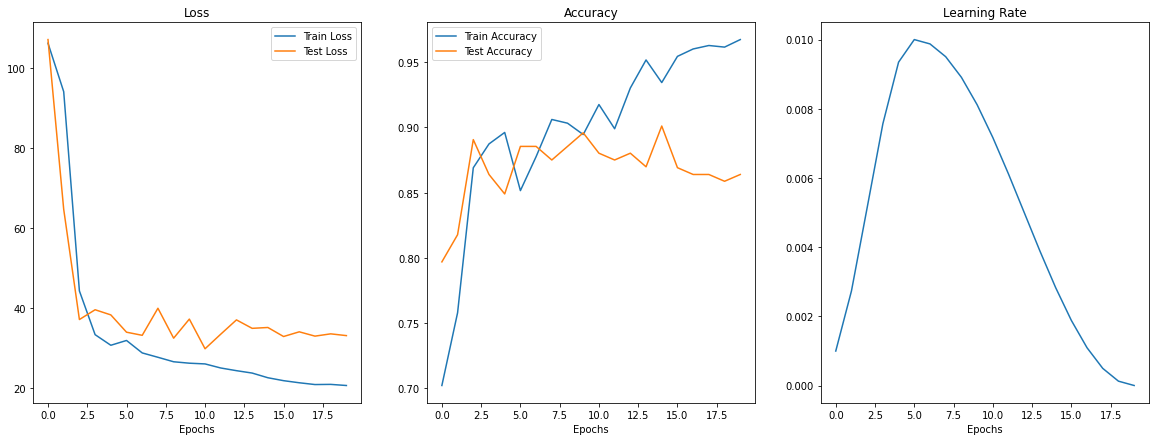

In [31]:
# Visualizing the metrics collected durning the model training
plot_curves(model_result=history)

Batched Single image: torch.Size([1, 3, 224, 224])

[INFO]Ground Truth Bounding Box: tensor([ 85.8667,  77.2800, 135.1467, 113.1200]) and Class: speedlimit

[INFO]Predicted Bounding Box: tensor([ 78.9496,  78.0109, 119.1098, 115.4811]) and Class: speedlimit



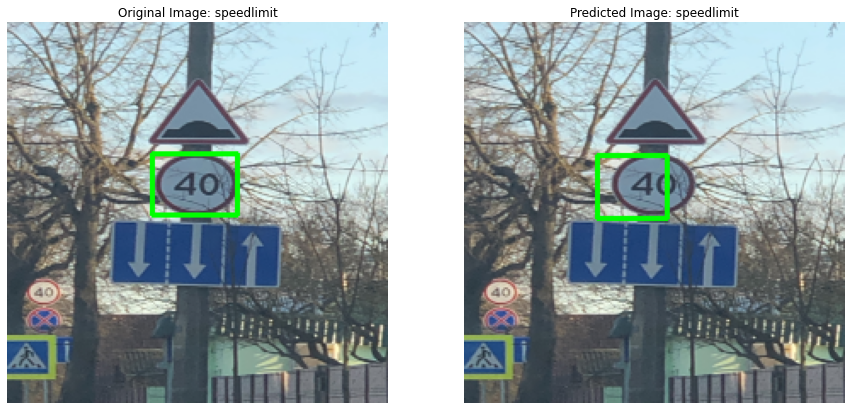

In [75]:
# Pulling a random data
rand_num = np.random.randint(len(dataset))
img, bbox, label = dataset[rand_num]
org_img = img.copy()

# Transforming the image into a batch
image = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)
print(f'Batched Single image: {image.shape}\n')

# Going into inference mode and predicting the bounding box and class
with torch.inference_mode():
    object_detection_model.eval()
    pred_bbox, pred_class_logits = object_detection_model(image)
pred_bbox = pred_bbox.cpu()
pred_class_logits = pred_class_logits.cpu()
pred_class = torch.argmax(torch.softmax(pred_class_logits, dim=1), dim=1).cpu()

print(f'[INFO]Ground Truth Bounding Box: {bbox[0]} and Class: {dataset.classes[label[0]]}\n')
print(f'[INFO]Predicted Bounding Box: {pred_bbox[0]} and Class: {dataset.classes[pred_class[0]]}\n') 

# Plotting and comparing both the images
plt.figure(figsize=(15, 7))

# Original image
plt.subplot(1, 2, 1)
img_bbox = draw_bboxes(img_array=img, bboxes=bbox, labels=label)
plot_image(img_array=img_bbox)
plt.title(f'Original Image: {dataset.classes[label[0]]}')

# Predicted image
plt.subplot(1, 2, 2)
pred_img_bbox = draw_bboxes(img_array=org_img, bboxes=pred_bbox, labels=pred_class)
plot_image(img_array=pred_img_bbox)
plt.title(f'Predicted Image: {dataset.classes[pred_class[0]]}');